<a href="https://colab.research.google.com/github/pavankumarbalijepalli/pr-phi2-vs-defog/blob/main/phi2_finetune_peft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pre-requisites and Model Load

Before we load the model, we will need to install the packages mentioned below. These packages do not come out of the box with Google Colab.

We also need to ensure that the correct runtime (for GPU) is selected. You can do this by clicking on `Runtime-->Change runtime type` in the File Menu above. For my project, I picked the T4 GPU, which comes with 16GB of CPU and GPU RAM.

In [1]:
#Check the system specs
!nvidia-smi

Wed Feb  7 09:28:03 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0              25W / 300W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
#Install the required packages for this project
!pip install einops datasets bitsandbytes accelerate peft flash_attn
!pip uninstall -y transformers
!pip install git+https://github.com/huggingface/transformers
!pip install --upgrade torch


Found existing installation: transformers 4.38.0.dev0
Uninstalling transformers-4.38.0.dev0:
  Successfully uninstalled transformers-4.38.0.dev0
  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-i91f9012
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-i91f9012
  Resolved https://github.com/huggingface/transformers to commit d9deddb4c18410a14952537a91099319ecedb869
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.38.0.dev0-py3-none-any.whl size=8457089 sha256=be365d5f2b32156750c07ed20b1caf38f16a0b77066706208a94d0a6ebed427a
  Stored in directory: /tmp/pip-ephem-wheel-cache-46l6umed/wheels/c0/14/d6/6c9a5582d2ac191ec0a483be151a4495fe1eb2a6706ca49f1b
Successfully built transformers


### Loading the Microsoft Phi-2 Model
The Phi-2 model is available on Hugging Face. You can read the details of it from https://huggingface.co/microsoft/phi-2
I am also loading the model in `4-bit` which is the "Quantization" part of QLORA. The memory footprint of this is much smaller then the default.
Apart from loading the model, we will also setup the tokenizer and ensure the proper settings.

In [3]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers import BitsAndBytesConfig

model_name = "microsoft/phi-2"
# Configuration to load model in 4-bit quantized
bnb_config = BitsAndBytesConfig(load_in_4bit=True,
                                bnb_4bit_quant_type='nf4',
                                bnb_4bit_compute_dtype='float16',
                                #bnb_4bit_compute_dtype=torch.bfloat16,
                                bnb_4bit_use_double_quant=True)


#Loading Microsoft's Phi-2 model with compatible settings
model = AutoModelForCausalLM.from_pretrained(model_name,
                                             device_map='auto',
                                             quantization_config=bnb_config,
                                             trust_remote_code=True)

# Setting up the tokenizer for Phi-2
tokenizer = AutoTokenizer.from_pretrained(model_name,
                                          add_eos_token=True,
                                          trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.truncation_side = "left"


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/863 [00:00<?, ?B/s]

configuration_phi.py:   0%|          | 0.00/9.26k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/phi-2:
- configuration_phi.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_phi.py:   0%|          | 0.00/62.7k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/phi-2:
- modeling_phi.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors.index.json:   0%|          | 0.00/35.7k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/564M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/7.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [5]:
print(f"Memory footprint: {model.get_memory_footprint() / 1e9} GB")

Memory footprint: 1.792884736 GB


## Login to Hugging Face
We will login to Hugging Face, so we can save the updated model weights when training is done. Make sure to use an access key that has write permissions. You can create one from the following location.

https://huggingface.co/settings/tokens

In [6]:
from huggingface_hub import notebook_login

notebook_login()

## Tokenize and Prep Dataset for Training

Next, we will load the WebGLM dataset. This dataset is a web-enhanced QA system based on General Language Model (GLM). You can find more information about this at https://huggingface.co/datasets/THUDM/webglm-qa.

I am taking a slice of data, as we will train our model for two epochs.

In [7]:
from datasets import load_dataset

#Load a slice of the WebGLM dataset for training and merge validation/test datasets
train_dataset = dataset = load_dataset("b-mc2/sql-create-context")
data_df = train_dataset['train'].to_pandas()

print(train_dataset)

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['question', 'answer', 'context'],
        num_rows: 78577
    })
})


In [8]:
import seaborn as sns

<Axes: xlabel='count', ylabel='difficulty'>

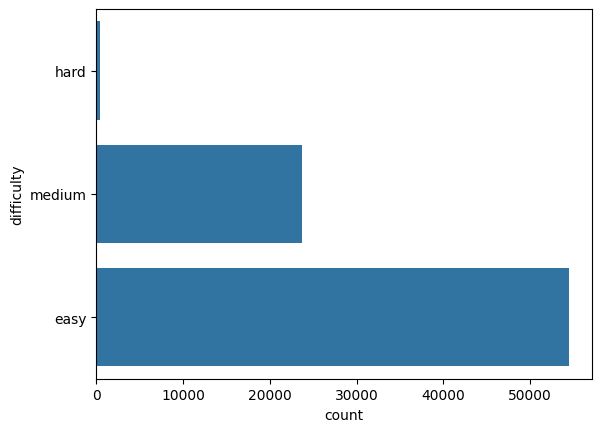

In [9]:
# Finding the complexity of the datapoint
data_df['table_count'] = data_df['context'].apply(lambda x: x.split(' ').count('CREATE'))
data_df['sub_query_count'] = data_df['answer'].apply(lambda x: x.split(' ').count('SELECT'))
data_df['joins_count'] = data_df['answer'].apply(lambda x: x.split(' ').count('JOIN'))
data_df['where_count'] = data_df['answer'].apply(lambda x: x.split(' ').count('WHERE'))
data_df['group_by_count'] = data_df['answer'].apply(lambda x: x.split(' ').count('GROUP BY'))
data_df['columns_count'] = data_df['context'].apply(lambda x: list(x).count(',')) + data_df['table_count']

# Finding the complexity based on the above values
data_df['complexity'] = data_df['table_count'] + data_df['sub_query_count'] + data_df['joins_count'] + data_df['where_count'] + data_df['group_by_count'] + data_df['columns_count']
data_df = data_df.sort_values(by='complexity', ascending=False)

# Marking Difficulty based on threshold
data_df['difficulty'] = data_df['complexity'].apply(lambda x: 'easy' if x < 6 else 'medium' if x < 13 else 'hard')
sns.countplot(data_df['difficulty'])

In [10]:
from sklearn.model_selection import train_test_split

# Split data into train and test set also maintaining the ratio in difficulty column
train_df, eval_df = train_test_split(data_df, test_size=0.1, stratify=data_df['difficulty'])
train_df, test_df = train_test_split(train_df, test_size=0.1, stratify=train_df['difficulty'])

train_df.shape, test_df.shape, eval_df.shape

((63647, 11), (7072, 11), (7858, 11))

In [11]:
from datasets import Dataset

train_dataset = Dataset.from_pandas(train_df, preserve_index=False)
eval_dataset = Dataset.from_pandas(eval_df, preserve_index=False)
test_dataset = Dataset.from_pandas(test_df, preserve_index=False)

In [12]:
train_dataset, eval_dataset, test_dataset

(Dataset({
     features: ['question', 'answer', 'context', 'table_count', 'sub_query_count', 'joins_count', 'where_count', 'group_by_count', 'columns_count', 'complexity', 'difficulty'],
     num_rows: 63647
 }),
 Dataset({
     features: ['question', 'answer', 'context', 'table_count', 'sub_query_count', 'joins_count', 'where_count', 'group_by_count', 'columns_count', 'complexity', 'difficulty'],
     num_rows: 7858
 }),
 Dataset({
     features: ['question', 'answer', 'context', 'table_count', 'sub_query_count', 'joins_count', 'where_count', 'group_by_count', 'columns_count', 'complexity', 'difficulty'],
     num_rows: 7072
 }))

In [13]:
#Function that creates a prompt from instruction, context, category and response and tokenizes it
def collate_and_tokenize_train(examples):
    question = examples["question"][0]
    answer = examples["answer"][0]
    context = examples['context'][0]

    #Merging into one prompt for tokenization and training
    prompt = f"""### Task
Generate a SQL query to answer the following question:
`{question}`

### Database Schema
The query will run on a database with the following schema:
{context}

### Answer
Given the database schema, here is the SQL query that answers `{question}`:
```sql
{answer}
```""".strip()

    #Tokenize the prompt
    encoded = tokenizer(
        prompt,
        return_tensors="np",
        padding="max_length",
        truncation=True,
        max_length=2048,
    )

    encoded["labels"] = encoded["input_ids"]
    return encoded

In [14]:
#Function that creates a prompt from instruction, context, category and response and tokenizes it
def collate_and_tokenize_test(examples):
    question = examples["question"][0]
    answer = examples["answer"][0]
    context = examples['context'][0]

    #Merging into one prompt for tokenization and training
    prompt = f"""### Task
Generate a SQL query to answer the following question:
`{question}`

### Database Schema
The query will run on a database with the following schema:
{context}

### Answer
Given the database schema, here is the SQL query that answers `{question}`:
```sql
""".strip()

    #Tokenize the prompt
    encoded = tokenizer(
        prompt,
        return_tensors="np",
        padding="max_length",
        truncation=True,
        max_length=2048,
    )

    encoded["labels"] = encoded["input_ids"]
    return encoded

In [15]:
#We will just keep the input_ids and labels that we add in function above.
columns_to_remove = ['question', 'context', 'answer', 'table_count', 'sub_query_count', 'joins_count', 'where_count', 'group_by_count', 'columns_count', 'complexity', 'difficulty']

#tokenize the training and test datasets
tokenized_dataset_train = train_dataset.map(collate_and_tokenize_train,
                                            batched=True,
                                            batch_size=1,
                                            remove_columns=columns_to_remove)

tokenized_dataset_eval = eval_dataset.map(collate_and_tokenize_train,
                                          batched=True,
                                          batch_size=1,
                                          remove_columns=columns_to_remove)

tokenized_dataset_test = test_dataset.map(collate_and_tokenize_test,
                                          batched=True,
                                          batch_size=1,
                                          remove_columns=columns_to_remove)


Map:   0%|          | 0/63647 [00:00<?, ? examples/s]

Map:   0%|          | 0/7858 [00:00<?, ? examples/s]

Map:   0%|          | 0/7072 [00:00<?, ? examples/s]

In [16]:
#Check if tokenization looks good
input_ids = tokenized_dataset_train[1]['input_ids']

decoded = tokenizer.decode(input_ids, skip_special_tokens=True)
print(decoded)

### Task
Generate a SQL query to answer the following question:
`What is Lost, when Drawn is "2", and when Points is "36"?`

### Database Schema
The query will run on a database with the following schema:
CREATE TABLE table_name_94 (lost VARCHAR, drawn VARCHAR, points VARCHAR)

### Answer
Given the database schema, here is the SQL query that answers `What is Lost, when Drawn is "2", and when Points is "36"?`:
```sql
SELECT lost FROM table_name_94 WHERE drawn = "2" AND points = "36"
```


# Training the model

We will be using LORA technique to train the model. This technique will significantly reduce the number of trainable parameters, giving better performance and memory utilization.

In [17]:
#Accelerate training models on larger batch sizes, we can use a fully sharded data parallel model.
from accelerate import FullyShardedDataParallelPlugin, Accelerator
from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig

fsdp_plugin = FullyShardedDataParallelPlugin(
    state_dict_config=FullStateDictConfig(offload_to_cpu=True, rank0_only=False),
    optim_state_dict_config=FullOptimStateDictConfig(offload_to_cpu=True, rank0_only=False),
)

accelerator = Accelerator(fsdp_plugin=fsdp_plugin)

In [18]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param:.2f}"
    )

In [19]:
from peft import prepare_model_for_kbit_training

print_trainable_parameters(model)

#gradient checkpointing to save memory
model.gradient_checkpointing_enable()

# Freeze base model layers and cast layernorm in fp32
model = prepare_model_for_kbit_training(model, use_gradient_checkpointing=True)
print(model)

trainable params: 262364160 || all params: 1521392640 || trainable%: 17.24
PhiForCausalLM(
  (model): PhiModel(
    (embed_tokens): Embedding(51200, 2560)
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-31): 32 x PhiDecoderLayer(
        (self_attn): PhiAttention(
          (q_proj): Linear4bit(in_features=2560, out_features=2560, bias=True)
          (k_proj): Linear4bit(in_features=2560, out_features=2560, bias=True)
          (v_proj): Linear4bit(in_features=2560, out_features=2560, bias=True)
          (dense): Linear4bit(in_features=2560, out_features=2560, bias=True)
          (rotary_emb): PhiRotaryEmbedding()
        )
        (mlp): PhiMLP(
          (activation_fn): NewGELUActivation()
          (fc1): Linear4bit(in_features=2560, out_features=10240, bias=True)
          (fc2): Linear4bit(in_features=10240, out_features=2560, bias=True)
        )
        (input_layernorm): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
        (re

In [20]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=None, #print(model) will show the modules to use
    bias="none",
    lora_dropout=0.05,
    task_type="CAUSAL_LM",
)

lora_model = get_peft_model(model, config)
print_trainable_parameters(lora_model)


lora_model = accelerator.prepare_model(lora_model)

trainable params: 18350080 || all params: 1539742720 || trainable%: 1.19


### Training the Model and saving to Hub
This is where, we setup the training arguments. These arguments have been carefully selected to improve memory utilization and also help increase performance. I played around with these for a while, before finalizing the following arguments.

Finally, I am saving the model weights to HuggingFace Hub, so we do not loose out work. The training can run for several hours and I usually keep it running overnight.

In [21]:
import time
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir='./results',  # Output directory for checkpoints and predictions
    overwrite_output_dir=True, # Overwrite the content of the output directory
    per_device_train_batch_size=2,  # Batch size for training
    per_device_eval_batch_size=2,  # Batch size for evaluation
    gradient_accumulation_steps=5, # number of steps before optimizing
    gradient_checkpointing=True,   # Enable gradient checkpointing
    gradient_checkpointing_kwargs={"use_reentrant": False},
    warmup_steps=50,  # Number of warmup steps
    #max_steps=1000,  # Total number of training steps
    num_train_epochs=2,  # Number of training epochs
    learning_rate=5e-5,  # Learning rate
    weight_decay=0.01,  # Weight decay
    optim="paged_adamw_8bit", #Keep the optimizer state and quantize it
    fp16=True, #Use mixed precision training
    #For logging and saving
    logging_dir='./logs',
    logging_strategy="steps",
    logging_steps=100,
    save_strategy="steps",
    save_steps=100,
    save_total_limit=2,  # Limit the total number of checkpoints
    evaluation_strategy="steps",
    eval_steps=100,
    load_best_model_at_end=True, # Load the best model at the end of training
)

trainer = Trainer(
    model=lora_model,
    train_dataset=tokenized_dataset_train,
    eval_dataset=tokenized_dataset_test,
    args=training_args,
)

In [22]:
#Disable cache to prevent warning, renable for inference
model.config.use_cache = False

start_time = time.time()  # Record the start time
trainer.train()  # Start training
end_time = time.time()  # Record the end time

training_time = end_time - start_time  # Calculate total training time

print(f"Training completed in {training_time} seconds.")

#Save model to hub to ensure we save our work.
lora_model.push_to_hub("phi2-sql-cc-qlora",
                  use_auth_token=True,
                  commit_message="Training Phi-2",
                  private=True)


#Terminate the session so we do not incur cost
from google.colab import runtime
runtime.unassign()

OutOfMemoryError: CUDA out of memory. Tried to allocate 800.00 MiB. GPU 0 has a total capacity of 15.77 GiB of which 788.38 MiB is free. Process 68867 has 15.00 GiB memory in use. Of the allocated memory 12.96 GiB is allocated by PyTorch, and 1.67 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
#Save model to hub to ensure we save our work.
lora_model.push_to_hub("phi2-webglm-qlora",
                  use_auth_token=True,
                  commit_message="Training Phi-2",
                  private=True)

## Run Inference

**Note**: Ensure to stop your session and reconnect and reload the model before running the code below.

First we will run inference without the trained weights and check the output.

In [ ]:
#Setup a prompt that we can use for testing

new_prompt = """###System:
Read the references provided and answer the corresponding question.
###References:
[1] For most people, the act of reading is a reward in itself. However, studies show that reading books also has benefits that range from a longer life to career success. If you’re looking for reasons to pick up a book, read on for seven science-backed reasons why reading is good for your health, relationships and happiness.
[2] As per a study, one of the prime benefits of reading books is slowing down mental disorders such as Alzheimer’s and Dementia  It happens since reading stimulates the brain and keeps it active, which allows it to retain its power and capacity.
[3] Another one of the benefits of reading books is that they can improve our ability to empathize with others. And empathy has many benefits – it can reduce stress, improve our relationships, and inform our moral compasses.
[4] Here are 10 benefits of reading that illustrate the importance of reading books. When you read every day you:
[5] Why is reading good for you? Reading is good for you because it improves your focus, memory, empathy, and communication skills. It can reduce stress, improve your mental health, and help you live longer. Reading also allows you to learn new things to help you succeed in your work and relationships.
###Question:
Why is reading books widely considered to be beneficial?
###Answer:
"""


In [ ]:
inputs = tokenizer(new_prompt, return_tensors="pt",
                   return_attention_mask=False,
                   padding=True, truncation=True)

inputs.to('cuda')

outputs = model.generate(**inputs, repetition_penalty=1.0,
                              max_length=1000)
result = tokenizer.batch_decode(outputs, skip_special_tokens=True)

print(result)

Next, lets run the model with lora config and check inference on it.

In [ ]:
from peft import PeftModel, PeftConfig

#Load the model weights from hub
model_id = "praveeny/phi2-webglm-qlora"
trained_model = PeftModel.from_pretrained(model, model_id)

#Run inference
outputs = trained_model.generate(**inputs, max_length=1000)
text = tokenizer.batch_decode(outputs,skip_special_tokens=True)[0]
print(text)